## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 16 categories by training and testing on the 16
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---

The starter code trains on 150 and tests on 50 images from each category (i.e. 2400
training examples total and 800 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.

Download the [dataset(click me)](https://drive.google.com/file/d/1DBCPwgTPgwKe_oBQ_XhNTb9Gne5jFXQl/view?usp=sharing) and unzip it to obtain the 'data' directory. Copy this 'data' directory into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.25% accuracy
(1 out of 16 guesses is correct).

In [ ]:
 pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
import csv
import itertools
import time
import zipfile
import torch
import torchvision
import gc
import pickle
from sklearn import svm
from skimage import color
from skimage import io
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

print(cv2.__version__) # verify OpenCV version

3.4.2


In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
%cd '/content/gdrive/MyDrive/Meng_Alex_114477057_hw4'

/content/gdrive/MyDrive/Meng_Alex_114477057_hw4


## Data Preparation

In [ ]:
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples_per_class = 150
n_test_samples_per_class = 50

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dabottomtaset
# train_data, train_label = load_dataset('./data/train/')
train_data, train_label = load_dataset('./data/train/', n_train_samples_per_class)
n_train = len(train_label)
print("n_train: %s" % n_train)

# load testing dataset
# test_data, test_label = load_dataset('./data/test/')
test_data, test_label = load_dataset('./data/test/', n_test_samples_per_class)
n_test = len(test_label)
print("n_test: %s" % n_test)

class_names: {0: 'LivingRoom', 1: 'Bedroom', 2: 'OpenCountry', 3: 'Office', 4: 'Kitchen', 5: 'Industrial', 6: 'TallBuilding', 7: 'Coast', 8: 'Mountain', 9: 'Forest', 10: 'Store', 11: 'Street', 12: 'InsideCity', 13: 'Suburb', 14: 'Flower', 15: 'Highway'} 
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
n_train: 2400
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8


In [ ]:
def load_dataset_unlabeled(path):
    data = []
    img_all = glob.glob(path + '*.jpg')
    for img_path in img_all:
      data.append(cv2.imread(img_path, 0))
    return data

In [ ]:
test2_data = load_dataset_unlabeled('./data/test2/')
n_test2 = len(test2_data)
print("n_test: %s" % n_test2)
with open('test2.pkl', 'wb') as fp:
  pickle.dump(test2_data, fp)

n_test: 400


In [ ]:
# As loading the data from the source for the first time is time consuming, so you can pkl or save the data in a compact way such that subsequent data loading is faster
# Save intermediate image data into disk
file = open('train.pkl','wb')
pickle.dump(train_data, file)
pickle.dump(train_label, file)
file.close()

file = open('test.pkl','wb')
pickle.dump(test_data, file)
pickle.dump(test_label, file)
file.close()

In [ ]:
# Load intermediate image data from disk
file = open('train.pkl', 'rb')
train_data = pickle.load(file)
train_label = pickle.load(file)
file.close()

file = open('test.pkl', 'rb')
test_data = pickle.load(file)
test_label = pickle.load(file)
file.close()

print(len(train_data), len(train_label)) # Verify number of training samples
print(len(test_data), len(test_label))   # Verify number of testing samples

2400 2400
400 400


In [ ]:
file = open('test2.pkl', 'rb')
test2_data = pickle.load(file)
file.close()

print(len(test2_data)) # Verify number of samples in test2_data

400


In [ ]:
# plt.imshow(train_data[1], cmap='gray') # Verify image
img_new_size = (240, 240)

train_data = list(map(lambda x: cv2.resize(x, img_new_size), train_data))
train_data = np.stack(train_data)
train_label = np.array(train_label)

test_data = list(map(lambda x: cv2.resize(x, img_new_size), test_data))
test_data = np.stack(test_data)
test_label = np.array(test_label)


uint8


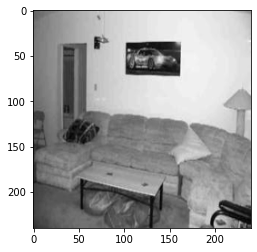

In [ ]:
# Verify image
plt.imshow(cv2.resize(train_data[1], img_new_size), cmap='gray')
print(train_data[0].dtype)

In [ ]:
n_train = len(train_label)
n_test = len(test_label)

# feature extraction
def extract_feat(raw_data):
    print(len(raw_data))
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in np.arange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
    print("Length of features",len(feat))
    
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(16) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in np.arange(n_test):
    predictions[i] = predict(None, test_feat[i])

accuracy = sum(np.array(predictions) == test_label) / float(n_test)

print("The accuracy of my dummy model is {:.2f}%".format(accuracy*100))

2400
Length of features 2400
400
Length of features 400
The accuracy of my dummy model is 7.00%


## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [ ]:
# Write your codes here
s = time.time()
trainData = np.array(np.stack(list(map(lambda x: cv2.resize(x, (16, 16)).flatten(), train_data))))
testData = np.array(np.stack(list(map(lambda x: cv2.resize(x, (16, 16)).flatten(), test_data))))

nnClassifier = NearestNeighbors(n_neighbors=1, metric='l2').fit(trainData)
distances, indices = nnClassifier.kneighbors(testData)

pred1 = []
for i in indices:
  pred1.append(train_label[i[0]])

acc = accuracy_score(test_label, pred1)*100
print('Tiny Image Representation and Nearest Neighbor Classifier Accuracy: ', acc, '%')

e = time.time() - s
print('Tiny Image Representation and Nearest Neighbor Classifier Total time: ', e, 'seconds')

Tiny Image Representation and Nearest Neighbor Classifier Accuracy:  19.25 %
Tiny Image Representation and Nearest Neighbor Classifier Total time:  0.053710222244262695 seconds


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

After you obtain the Bag of SIFT feature representation of the images, you have to
train a KNN classifier in the Bag of SIFT feature space and report your test set accuracy and time consumption. 

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).
- Be mindful of RAM usage. Try to make the code more memory efficient, otherwise it could easily exceed RAM limits in Colab, at which point your session will crash.
- If your RAM is going to run out of space, use [gc.collect()](https://docs.python.org/3/library/gc.html) for the garbage collector to collect unused objects in  memory to free some space.
- Store data or features as NumPy arrays instead of lists. Computation on NumPy arrays is much more efficient than lists.

In [ ]:
# creating SIFT
d= cv2.xfeatures2d.SIFT_create() 

diameter = 15

def get_keypoints(img):
    height, width = img.shape
    step_w = width/8
    step_h = height/8
    allKeyPoints = []
    ranges_w = np.arange(step_w/2,width,step_w)
    ranges_h = np.arange(step_h/2,height,step_h)
    for i in ranges_w:
        for j in ranges_h:
            allKeyPoints.append(cv2.KeyPoint(i,j,diameter,-1,0,0,-1))
    return allKeyPoints


def extract_sift(raw_data):
    feat_dim = (len(raw_data))
    feat = []
    for i in range(0,feat_dim):
        feat.append(get_descriptors(raw_data[i]))
    return feat


def get_descriptors(img):
    kp, des = d.compute(img, get_keypoints(img))
    return des

def extract_sift_feat_hist_kmeans(raw_data, kmeans):
    feat_dim = (len(raw_data))
    feat = []
    for i in range(0,feat_dim):
        feat.append(get_hist_kmeans(raw_data[i], kmeans)) 
    return feat

def get_hist_kmeans(img_sift, kmeans):
    cen_size = len(kmeans.cluster_centers_)
    histogram = np.repeat(0,cen_size) 
    for each in img_sift: 
        min_index= kmeans.predict(each.reshape(1,-1))
        histogram[min_index]+=1 
    return (histogram+0.0)/np.sum(histogram)

In [ ]:
time_taken_universal = 0

s = time.time()
train_sift = extract_sift(train_data)
test_sift = extract_sift(test_data)
e = time.time()
print("Extract SIFT descriptors")
print("Time: " + str(e-s))
time_taken_universal += (e-s)
print("Total time taken uptil now: " + str(time_taken_universal))

Extract SIFT descriptors
Time: 40.02436637878418
Total time taken uptil now: 40.02436637878418


In [ ]:
time_taken = time_taken_universal
all_train_sifts = np.array(train_sift).reshape(len(train_sift)*len(train_sift[0]),len(train_sift[0][0]))

s = time.time()
kMeans_train = KMeans(n_clusters = 100, random_state = 0).fit(all_train_sifts)
e = time.time()


print("Cluster training SIFT descriptors")
print("Time: " + str(e-s))
time_taken += (e-s)
print("Total time taken uptil now: " + str(time_taken))

Cluster training SIFT descriptors
Time: 301.7875576019287
Total time taken uptil now: 341.8119239807129


In [ ]:
s = time.time()
siftHist = extract_sift_feat_hist_kmeans(train_sift, kMeans_train)
siftHistTest = extract_sift_feat_hist_kmeans(test_sift, kMeans_train)
e = time.time()

print("Make histograms")
print("Time: " + str(e-s))
time_taken += (e-s)
print("Total time taken uptil now: " + str(time_taken))

Make histograms
Time: 34.88122510910034
Total time taken uptil now: 376.69314908981323


In [ ]:
s = time.time()
siftHist = np.array(siftHist)
siftHistTest = np.array(siftHistTest)
kNNClassifier = KNeighborsClassifier(n_neighbors=30, weights='distance')
kNNClassifier.fit(siftHist, train_label)
pred2 = kNNClassifier.predict(siftHistTest)
knnAcc = accuracy_score(test_label, pred2)*100
e = time.time()

print('Bag of SIFT Representation and Nearest Neighbor Classifer Accuracy: ', knnAcc, '%')
time_taken += (e-s)
print('Bag of SIFT Representation and Nearest Neighbor Classifer Total time: ' + str(time_taken))

Bag of SIFT Representation and Nearest Neighbor Classifer Accuracy:  51.0 %
Bag of SIFT Representation and Nearest Neighbor Classifer Total time: 376.88460993766785


## Problem 3.a: Bag of SIFT Representation + one-vs-all SVMs
{15 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 16-way classification problem
(the library has handled it for you). To decide which of 16 categories a test
case belongs to, you will train 16 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 16 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: For this question, you need to generate class prediction for the images in **test2** folder using your best model. The prediction file(**Surname_Givenname_SBUID_Pred.txt**) should follow the exact format as given in the **sample.txt** file.10 points will be given to students whose accuracy ranks top 3 in this homework.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [ ]:
# Write your codes here
def oneVsAllSVM(trainHist, testHist, train_label, test_label, lambd):
  svmClassifier = svm.SVC(C=lambd, kernel='linear', probability=True).fit(trainHist, train_label)
  pred = svmClassifier.predict(testHist)
  acc = accuracy_score(test_label, pred)*100
  return acc, pred

startTime = time.time()
lambd = 1000
svmAcc, pred3 = oneVsAllSVM(siftHist, siftHistTest, train_label, test_label, lambd)
endTime = time.time() - startTime
print('Bag of SIFT Representation and one-vs-all SVMs Accuracy of:', svmAcc,'%')
print(' Bag of SIFT Representation and one-vs-all SVMs Total time: ', endTime,'s')

Bag of SIFT Representation and one-vs-all SVMs Accuracy of: 61.75000000000001 %
 Bag of SIFT Representation and one-vs-all SVMs Total time:  1.535524606704712 s


In [ ]:
print("Predicting for test2:")

# totalTime = 0

s = time.time()
test2_sift = extract_sift(test2_data)
e = time.time()

print("Extract SIFT descriptors")
print("Time: " + str(e-s))

s = time.time()
siftHist2Test = extract_sift_feat_hist_kmeans(test2_sift, kMeans_train)
e = time.time()

print("Make histograms")
print("Time: " + str(e-s))




# totalTime += (e-s)
# print("Total time taken uptil now: " + str(time_taken_universal))



Predicting for test2:
Extract SIFT descriptors
Time: 9.148224353790283
Make histograms
Time: 4.846520662307739


In [ ]:
# THIS BLOCK PRINTS OUT ALL FILES IN TEXT2
# Returns an array of all file names in test2
def load_dataset_names(path):
  data = ['Name']
  img_all = glob.glob(path + '*.jpg')
  for name in img_all:
    data.append(os.path.basename(name))
  return data

data = load_dataset_names('./data/test2/')



In [ ]:
svmAcc, pred4 = oneVsAllSVM(siftHist, siftHist2Test, train_label, test_label, 1000)

y = ['Class_id']
for elem in pred4:
  y.append(elem)

merged = np.array(list(zip(data, y)))

with open('/content/gdrive/MyDrive/Meng_Alex_114477057_hw4/Meng_Alex_114477057_Pred.txt', 'w') as f:
      for line in merged:
        f.write(line[0] + " " + line[1] + "\n")

## Problem 3.b
{5 points} Repeat the evaluation above for different sizes of training sets and draw a plot to show how the size of the training set affects test performace. Do this for training set sizes of 800, 1200, 1600, 2000, 2200, and 2300 images. Randomly sample the images from the original training set and evaluate accuracy. Repeat this process 10 times for each training set size and report the average prediction accuracy. How does performance variability change with training set size? How does performance change? Give reason for your observations.

In [ ]:
# Write your codes here
trainingSizes = [800, 1200, 1600, 2000, 2200, 2300]
acc = []

for size in trainingSizes:
  avg = 0
  for i in range(10):
    trainHistSample, trainLabelSample = zip(*random.sample(list(zip(siftHist, train_label)), size))
    svmAcc, pred3 = oneVsAllSVM(trainHistSample, siftHistTest, trainLabelSample, test_label, 1000)
    avg += svmAcc
  avg = avg/10
  acc.append(avg)
  print('Accuracy for training set size ', size, ' is ', avg, '%')

Accuracy for training set size  800  is  51.55 %
Accuracy for training set size  1200  is  54.375 %
Accuracy for training set size  1600  is  56.675 %
Accuracy for training set size  2000  is  58.525 %
Accuracy for training set size  2200  is  59.4 %
Accuracy for training set size  2300  is  60.0 %


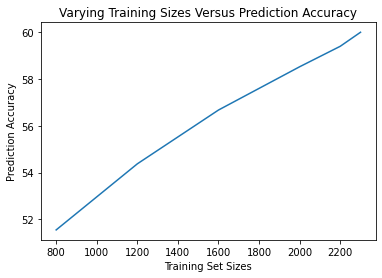

In [ ]:
plt.plot(trainingSizes, acc)
plt.title("Varying Training Sizes Versus Prediction Accuracy")
plt.xlabel("Training Set Sizes")
plt.ylabel("Prediction Accuracy")
plt.show()

Based on the graph 'Varying Training Sizes Versus Prediction Accuracy', we can see that as training set sizes goes up, prediction accuracy goes down. This is because generally the more data we have, the more data the model can learn from so the more accurate it can predict. The variance, therefore the standard deviation, goes down because the training set sizes is larger.

## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 40-50%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 50-70%). <br>

**1st: Tiny Image Representation and Nearest Neighbor Classifier**

*Accuracy:* about 19.3%

*Total Time to Complete:* about 0.0888 sec

The algorithm was to first extract tiny images, resizing each image to (16,16), and using them as inputs to a nearest neighbor classifier using ‘l2’ distance. This algorithm was fast, simple and trivial, thus a low accuracy of only around 19 percent.
 
Based on the normalized confusion matrix, the method performed best for suburbs, with a shocking 1.00 score, and second was street images with a 0.60 score, and third were flower images with a score of 0.55. It might just be a coincidence that suburb images worked very well with this method. All other categories the method did not work well.



**2nd: Bag of SIFT Representation and Nearest Neighbor Classifier**
 
*Accuracy:* about 51.0%
 
*Total Time to Complete:* about 376.72 sec
 
The algorithm was to cluster the images into SIFT features, form histograms by using kMeans.predict() method to predict which cluster each image lies and create the histogram, and then use the k-nearest neighbor classifier to classify a given test image. 
 
I tried various hyperparameters with this algorithm. First experimenting with the number of SIFTs per image, I found that 100 works the best from 50-150. I then chose to use 64 key points that are evenly spaced for each image with the diameter of 20. I first chose a diameter of 8, but increasing it to 20 gave a much higher accuracy from 45% to 51%. Then for the knnClassifier, I chose 30 as the number of neighbors.
 
Based on the normalized confusion matrix, the algorithm performed better than the first method overall but only with 3 out of 16 that's higher than 0.60 correct score. But overall, for each category the algorithm predicted correctly, assigning the correct label.



**3rd: Bag of SIFT Representation and Linear SVM Classifier**
 
*Accuracy:* about 61.75%
 
*Total Time to Complete:* about 1.11 sec
 
The algorithm was to use the SIFT features computed in problem 2 and feed them into an SVM. For this part, I experimented with various lambda values from 100-2000 in 100 increments, and found that 1000 works the best, which gave an accuracy of almost 62%.
 
Based on the normalized confusion matrix, 9 out of 16 categories had a predicted score greater than 0.60, a lot more compared to before. The categories that performed worst were industrial and bedroom, with 0.21 and 0.30 respectively.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


<Figure size 864x864 with 0 Axes>

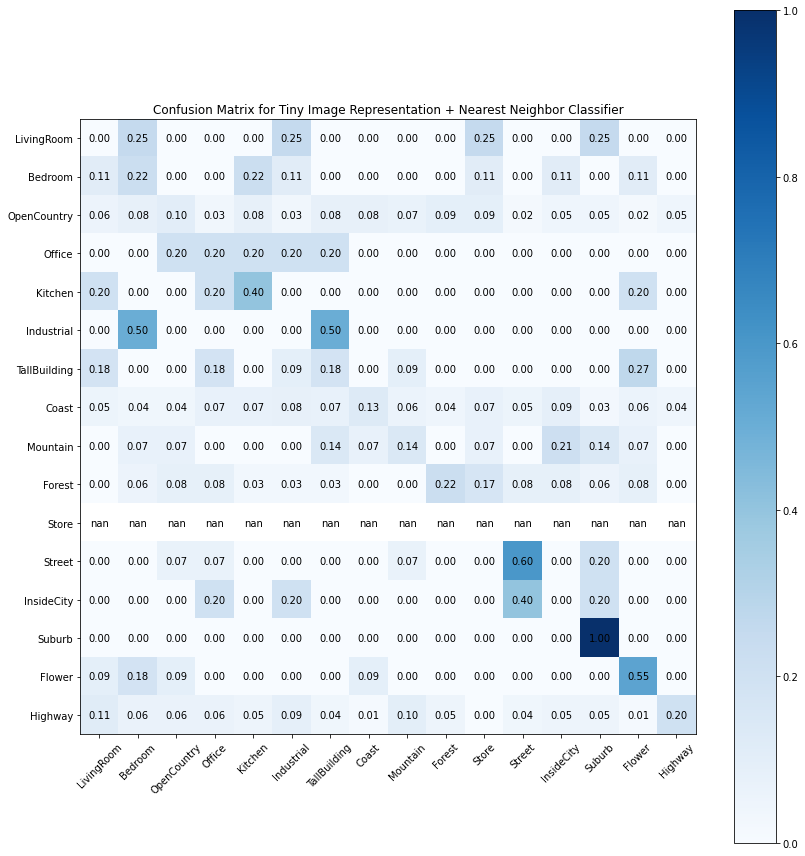

<Figure size 864x864 with 0 Axes>

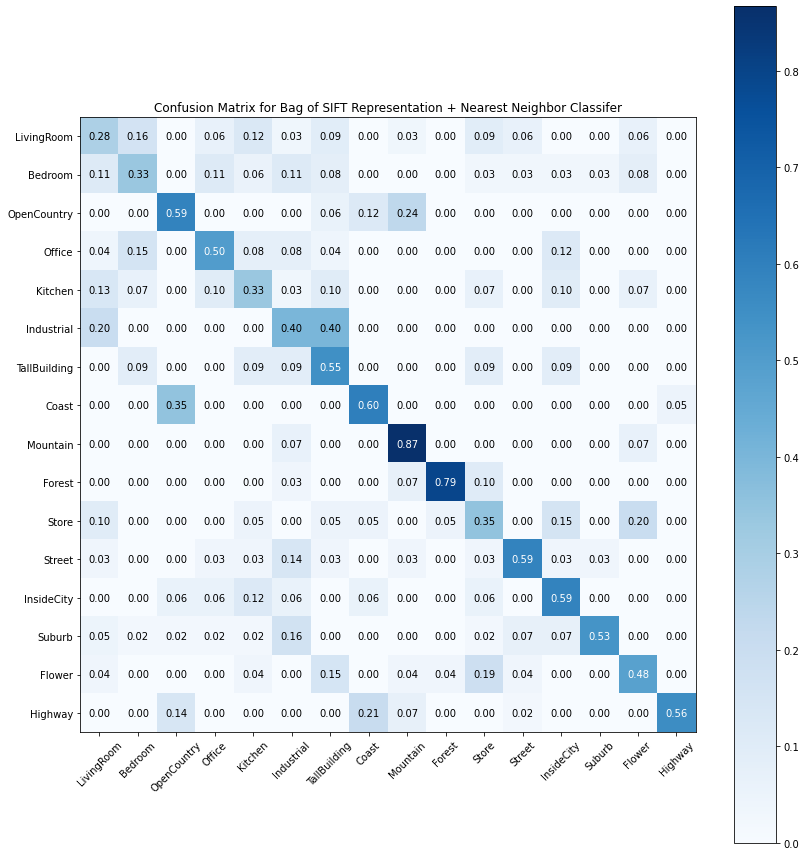

<Figure size 864x864 with 0 Axes>

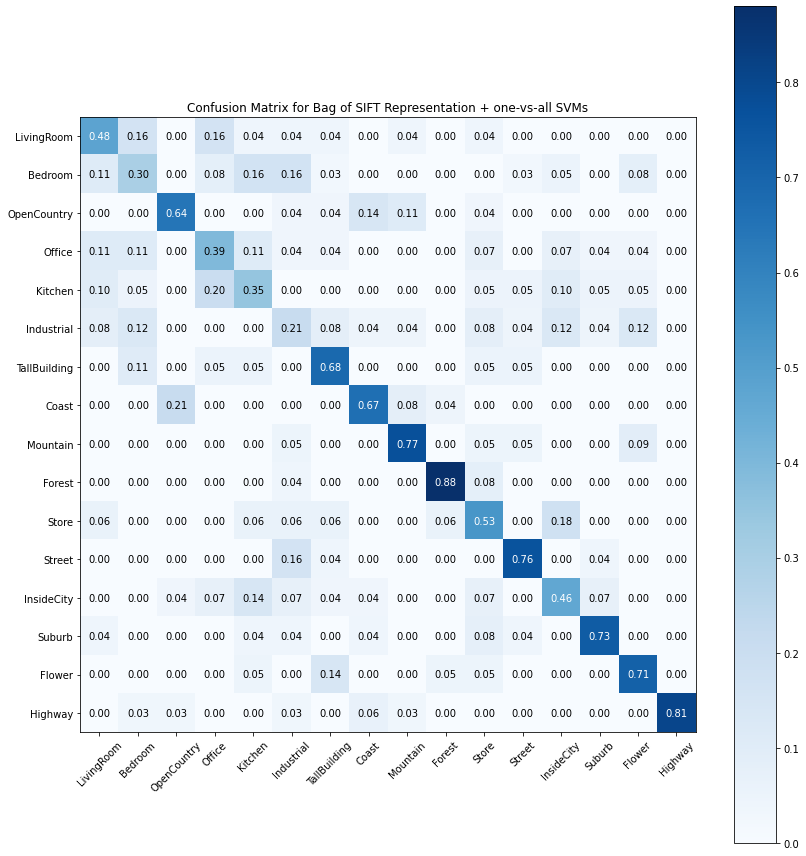

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for x in range(cm.shape[0]):
      for y in range(cm.shape[1]):
        plt.text(y, x, format(cm[x, y], fmt),
                            ha="center", 
                            va="center",
                            color="white" if cm[x, y] > thresh else "black")
        
    plt.tight_layout()


c_names = [name[13:] for name in glob.glob('./data/train/*')]

#First combination:
# Confusion matrix
cm1 = confusion_matrix(pred1, test_label)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True, title='Confusion Matrix for Tiny Image Representation + Nearest Neighbor Classifier')
plt.show()

# #Second combination:
# # Confusion matrix
cm2 = confusion_matrix(pred2, test_label)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True, title='Confusion Matrix for Bag of SIFT Representation + Nearest Neighbor Classifer')
plt.show()

# #Third combination:
# # Confusion matrix
cm3 = confusion_matrix(pred3, test_label)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True, title='Confusion Matrix for Bag of SIFT Representation + one-vs-all SVMs')
plt.show()